## A Modeling & Deployment Exercise by State Farm for MLE

This notebook is a first attempt at modeling a case from State Farm. The notebook that was provided contains useful methods and information about the data that being dealt with. However, there are several inconsistencies in the provided notebook. They are not limited to:

- The raw original dataset does not contain any date-like columns
- The application of removing the dollar sign was applied to several features that were not needed
- The use of regression when the target variable is not continuous but binary

Furthermore, there was no in-depth explanation as to why some of the features were removed. Hence, the aim of this notebook is hopefully address these inconsistencies and generate a good-enough model for classification. Optimizing the AUC score is one thing but what exactly is the business case? This is an ingredient that is missing and when handy will properly steer the direction of this project.

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                 import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble        import RandomForestClassifier

import json
import pickle

%matplotlib inline

print(np.__version__)

1.19.0


## Load Data Files

In [2]:
df_train_raw = pd.read_csv('./data/exercise_06_train.csv')
df_test_raw  = pd.read_csv('./data/exercise_06_test.csv')

In [3]:
#cc = df_train_raw.drop(['y'], axis = 1)
#cc.to_json('./data/exercise_06_train_drop_y.json',orient='records',index=True,lines=True)

In [4]:
# Convert all to training raw string for later testing p
#cc = cc.applymap(str)
#cc.to_json('./data/exercise_06_train_str_drop_y.json',orient='records',index=True,lines=True)

In [5]:
dd = df_test_raw.applymap(str)
dd.to_json('./data/exercise_06_holdout_str.json',orient='records')

In [6]:
df_train_raw.shape

(40000, 101)

In [7]:
df_test_raw.shape

(10000, 100)

In [8]:
# Put these in a variable
num_train = len(df_train_raw)
num_test = len(df_test_raw)

The test data is one column short since the target variable is missing

In [9]:
df_train_raw.describe()

,x0,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
count,39990.000000,39994.000000,39991.000000,39994.000000,39991.000000,39991.000000,39988.000000,39994.000000,39992.000000,39991.000000,...,39996.000000,39996.000000,39992.000000,39991.000000,39992.000000,39987.000000,39991.000000,39994.000000,39989.000000,40000.000000
mean,-6.227324,-0.003631,3.263137,-0.011791,-0.194883,0.010383,1.356893,-5.772306,0.048048,0.010670,...,0.012280,0.000891,2.827068,-0.168331,1.402239,0.017075,-0.029050,-6.293150,-0.004016,0.202875
std,32.884089,3.173933,22.169602,3.166725,26.718008,4.130731,36.325197,102.849135,5.627881,4.326084,...,8.026413,0.107292,14.879884,39.032408,34.405960,2.849403,4.680817,35.467566,3.736728,0.402145
min,-135.390427,-13.050915,-96.407854,-13.129254,-113.134234,-17.051988,-149.371319,-402.685028,-22.408535,-18.826790,...,-33.851792,-0.444247,-59.220256,-145.432017,-138.359394,-11.420638,-20.394743,-147.169513,-16.125627,0.000000
25%,-28.346711,-2.162244,-11.552185,-2.153462,-18.043956,-2.808966,-22.780167,-74.311341,-3.716091,-2.901715,...,-5.417175,-0.072001,-7.051826,-26.510699,-21.690995,-1.890783,-3.179707,-30.233969,-2.527217,0.000000
50%,-6.336736,-0.012382,3.102505,-0.003128,-0.034942,0.017516,1.688819,-6.161974,0.068615,0.018151,...,0.066692,0.000825,2.826360,0.055396,1.351155,0.018116,-0.007754,-6.337003,-0.003896,0.000000
75%,15.920506,2.156365,18.073905,2.120751,17.895429,2.795949,26.155026,63.662019,3.835864,2.922207,...,5.435815,0.073810,12.769598,25.980973,24.784234,1.927068,3.106575,17.565666,2.508722,0.000000
max,130.289496,15.913158,93.923565,12.925425,98.938324,15.312540,145.258013,409.690180,22.281267,18.235211,...,35.100962,0.447370,64.628225,165.921125,138.112172,10.683489,20.410253,138.430649,14.973584,1.000000


Looks like there are few missing rows

In [10]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, x0 to y
dtypes: float64(94), int64(1), object(6)
memory usage: 30.8+ MB


Here 'y' is the target variable with an integer type. 

In [11]:
# Let's extract categorical columns and take a look
cat_cols_temp = df_train_raw.dtypes[df_train_raw.dtypes == 'object'].index

In [12]:
# Let's take a look a closer look at the categorical data
df_cat = df_train_raw[list(cat_cols_temp)]
df_cat.head()

,x1,x12,x54,x79,x82,x84
0,thur,$567.15,Jun,0.01%,asia,Toyota
1,thur,($222.52),Aug,-0.01%,asia,bmw
2,wed,$55.12,Jun,0.00%,asia,volkswagon
3,thurday,($698.53),Aug,-0.01%,euorpe,Toyota
4,thurday,($486.68),July,-0.01%,asia,Toyota


The above states that we need to clean x12 and x79. This will be done later.

In [13]:
# Let's examine the target class
num_class_1 = df_train_raw['y'].sum()
print('Number of Class 1s: ', num_class_1)
print('Percentage of Class 1s: {:.2%}'.format(num_class_1/num_train))

Number of Class 1s:  8115
Percentage of Class 1s: 20.29%


So yes, it is imbalanced but not severely

In [14]:
# Take a look at the percentange of missing values per column
# I like this method. Learn something new everyday!
null_train_pct = df_train_raw.isnull().sum()/float(num_train)*100

print(len(null_train_pct[:-1]))

100


<Figure size 432x288 with 0 Axes>

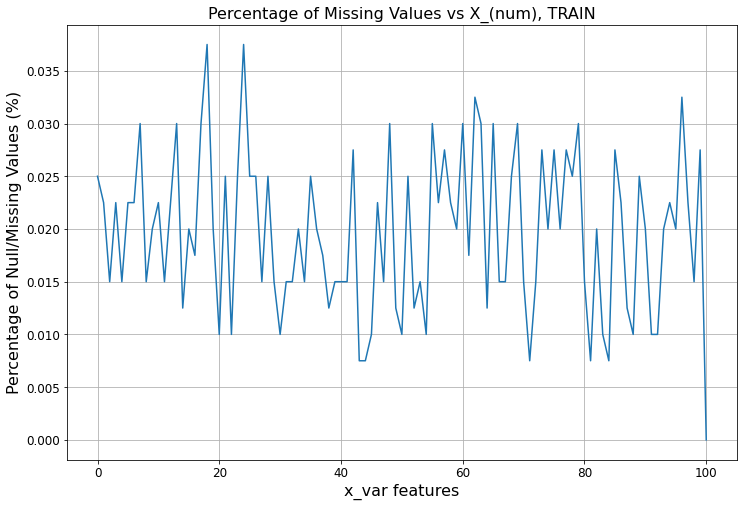

In [15]:
# Let's plot the distribution
x_variable = list(range(0,len(null_train_pct)))

fig = plt.figure();
plt.figure(figsize=(12,8));
plt.plot(x_variable,null_train_pct);
plt.xlabel('x_var features', fontsize=16);
plt.ylabel('Percentage of Null/Missing Values (%)', fontsize=16);
plt.title('Percentage of Missing Values vs X_(num), TRAIN', fontsize=16);
plt.tick_params(labelsize=12);
plt.grid();
plt.show();


From the above, the percentage distribution of missing values across variables is banded by 0.01% to 0.03% which is a rather small number. **The last index, 100, is the y target. No missing values.**

In [16]:
# Let's take a look at the test dataset
df_test_raw.describe()

,x0,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
count,9998.000000,9999.000000,9997.000000,9997.000000,9997.000000,9998.000000,9999.000000,9999.000000,9998.000000,9997.000000,...,9998.000000,9998.000000,9997.000000,10000.000000,9998.000000,9999.000000,9999.000000,9997.000000,10000.000000,9996.000000
mean,-6.034506,-0.032019,3.437874,-0.031043,-0.366806,0.011196,1.842939,-5.341586,-0.073698,0.016630,...,0.005758,0.085577,-0.002034,2.935843,0.008639,1.214429,-0.014826,0.011718,-7.217343,0.003926
std,33.057766,3.145554,22.474320,3.145244,26.679289,4.133687,36.452003,100.694021,5.660911,4.330269,...,4.666989,8.020340,0.107558,14.999175,38.801239,34.402609,2.859207,4.668887,35.697071,3.734014
min,-143.690776,-14.698761,-83.560606,-12.100369,-117.625832,-16.790410,-128.680296,-402.927564,-23.288204,-15.291569,...,-18.599408,-31.240534,-0.456978,-57.673842,-144.684866,-146.005620,-10.674883,-18.516694,-142.573806,-15.293302
25%,-28.092432,-2.102759,-11.735893,-2.130385,-18.101126,-2.811298,-22.337992,-72.326428,-3.897035,-2.967245,...,-3.119896,-5.341284,-0.074568,-7.202663,-26.153251,-22.345653,-1.966121,-3.177167,-31.347903,-2.541905
50%,-5.980225,-0.057019,3.478853,-0.062823,-0.067570,0.032146,2.053241,-5.039696,-0.098616,-0.000935,...,0.025968,0.143197,-0.003082,3.006865,-0.443289,1.289625,-0.041127,0.005723,-7.821605,-0.001595
75%,16.432319,2.062347,18.644323,2.075746,17.776241,2.792297,26.839027,62.651034,3.761357,2.936600,...,3.169904,5.553264,0.070297,12.940310,25.615566,24.545074,1.904048,3.190724,16.872573,2.526228
max,132.850436,12.396984,81.376532,10.990054,107.794149,14.887495,125.553701,361.495217,22.352095,17.577883,...,16.240693,28.227937,0.429505,66.697151,139.696178,123.863913,11.951755,18.416948,126.884076,13.824312


Several missing data here as well

<Figure size 432x288 with 0 Axes>

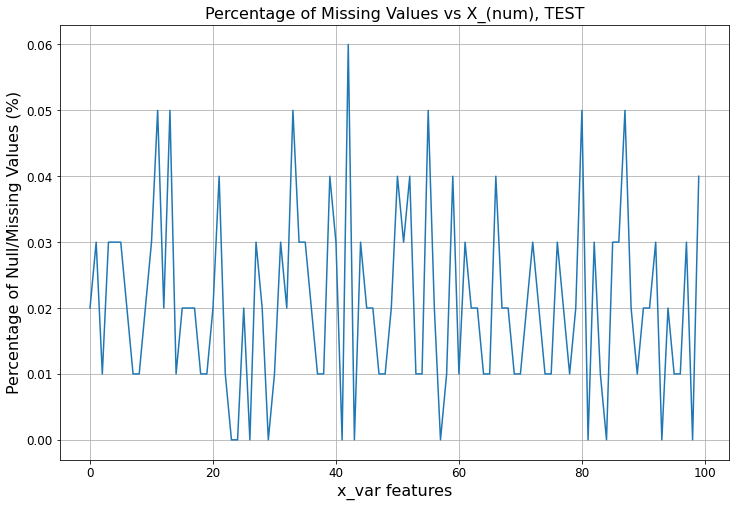

In [17]:
# Take a look at the percentange of missing values per column for the test set
null_test_pct = df_test_raw.isnull().sum()/float(num_test)*100

fig = plt.figure();
plt.figure(figsize=(12,8));
plt.plot(x_variable[:-1],null_test_pct);
plt.xlabel('x_var features', fontsize=16);
plt.ylabel('Percentage of Null/Missing Values (%)', fontsize=16);
plt.title('Percentage of Missing Values vs X_(num), TEST', fontsize=16);
plt.tick_params(labelsize=12);
plt.grid();
plt.show();

<Figure size 432x288 with 0 Axes>

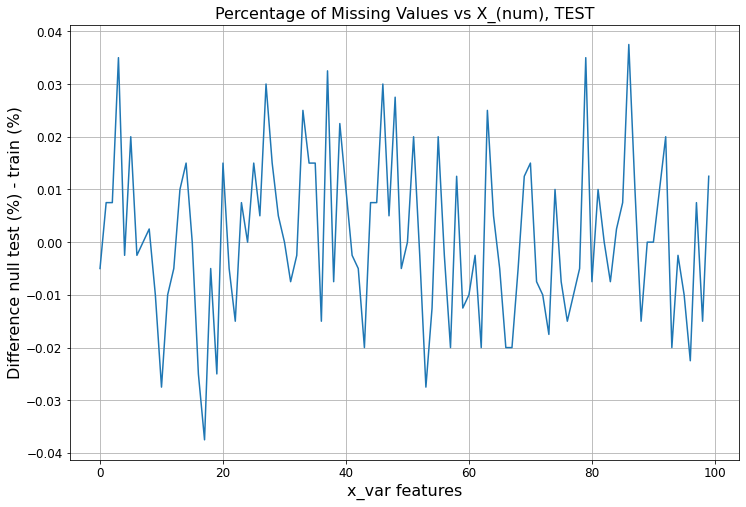

In [18]:
# Let's take a diff and see what the delta looks like sans target variable
diff_x_var = null_test_pct - null_train_pct

fig = plt.figure();
plt.figure(figsize=(12,8));
plt.plot(x_variable[:-1],diff_x_var[:-1]);
plt.xlabel('x_var features', fontsize=16);
plt.ylabel('Difference null test (%) - train (%)', fontsize=16);
plt.title('Percentage of Missing Values vs X_(num), TEST', fontsize=16);
plt.tick_params(labelsize=12);
plt.grid();
plt.show();

The purpose above is to look at the missing values in the train and test. Just visually though it appears that there are more missing values in the test set than in the train set. This conclusion is not in-depth. 

### Some notes

In the provided jupyter notebook, the train and test dataframes are combined into one. The reason for doing has mainly to do with converting the categorical features into numerical data. For the categorical features listed above, some days, months, region, and automobile make are spelled incorrectly. There is no point going into correct these since the dataset is so large and could get even larger. To effectively account for all possibilities in the categorical feature, we will just combine train and test and label encode them. Once this is done, they are then separated for training.

In [19]:
# Before we delete the data frames, lets extract the target variable.
# We are sure that none of the target values are missing.
y = df_train_raw['y']

del df_train_raw['y']

In [20]:
# Now let's combine the train and test dataframes
df_raw = pd.concat([df_train_raw, df_test_raw],ignore_index=True)

In [21]:
# To save memory space, let's delete the df_train_raw and df_test_raw
del df_train_raw
del df_test_raw

In [22]:
# Let's take a look at the size
df_raw.shape

(50000, 100)

In [23]:
df_raw.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
0,-18.801830,thur,-6.552566,9.538784,1.312835,-30.919756,-1.746701,10.353219,7.540528,2.367213,...,2.346655,1.123002,0.100649,-2.289470,-31.647151,33.027017,0.185422,6.273963,13.979704,-6.463642
1,-10.067812,thur,0.729611,20.360833,-3.613123,-17.570984,2.543479,-15.372645,115.017876,6.575745,...,3.118563,2.164270,0.115138,-10.523961,-43.017759,-13.975430,-1.361422,0.013210,-29.676227,-0.632905
2,32.090898,wed,0.337504,0.656304,1.486507,-41.844111,-6.575336,-35.273596,69.702872,6.776646,...,-2.677601,4.791612,0.188479,-13.207637,-36.059895,-10.711337,8.228320,0.944817,-1.313898,-4.071025
3,8.032520,thurday,-1.066729,-26.137688,1.239016,10.016360,0.750321,-0.189688,54.489425,7.047990,...,-0.616081,-6.865662,-0.237309,-18.353940,-33.980075,49.143130,3.353182,-4.094337,11.922088,-2.627234
4,-29.852847,thurday,5.551189,6.719916,-0.844864,24.908333,-3.633462,-10.470385,-46.300708,-11.035877,...,-0.655409,5.501678,0.146089,1.150860,-8.455681,3.111147,1.256273,-3.909616,-18.668604,-0.831601


In [24]:
# Note the NaN for target y at the tail end of it
df_raw.tail()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99
49995,42.487717,wednesday,-4.130542,22.038610,-2.172536,-11.768441,-4.564670,-44.135020,-213.921563,9.847965,...,0.461091,15.269343,0.014460,7.206053,-9.939702,32.541468,-6.803338,1.401432,18.494866,-4.783878
49996,-7.192815,wed,3.270981,-8.402407,-4.143773,-11.717519,0.232959,22.852788,-39.134705,-7.502614,...,0.920426,3.337998,-0.031179,8.324772,50.739629,-16.712595,0.394238,1.468364,19.994687,-0.568074
49997,8.793212,thurday,-1.393157,-6.314145,3.326924,-13.012858,1.016672,17.975472,8.199340,-2.212123,...,1.500479,-7.847651,-0.047705,-27.068454,-35.265855,54.182808,4.833496,1.122274,38.506203,-1.528920
49998,-43.454876,thur,0.632218,16.436369,-0.472492,-21.230454,-2.127770,-4.278341,-48.637476,-3.139096,...,-5.687137,9.773085,0.158917,-2.759867,-25.900913,-10.685545,6.691167,-6.180916,48.543568,-2.380228
49999,-16.242451,tuesday,4.240384,19.777380,-3.465630,13.736478,-3.372487,16.525887,60.977834,4.802240,...,2.494329,3.201127,-0.122041,2.556874,43.947591,5.497269,-1.001234,1.765095,-61.186489,-6.168738


## Feature Selection & Engineering

The original provided notebook made several changes to the variables

- Deleted x2, x3, x19 because according to the comments it was not needed for modeling?
- Deleted x10, x16, x18 because NLP was required thus increasing the complexity of the model?
- Deleted x8 because it was redundant?
- Created 'new' features to be used in modeling --> x33 = x5/x4 and x34 = x6/x5?
- x15 and x23 converted to years? The current data does not appear to be in years.

The given reasons above are rather light in reason and no in-depth discussion. There was also several feature engineering involved with not much explanation involved. Clearly I am not privy to the information before-hand. Moving forward, I will assume that what I am handed is a blind-test. I will implement the suggested feature engineering methods in another section and compare the AUC score...time permitting.

In [25]:
# Let's drop duplicate rows if any
df_raw = df_raw.drop_duplicates()

# Let's check the shape. If it is the same then there are no duplicate rows.
df_raw.shape

(50000, 100)

OK no duplicate rows!

In [26]:
# Let's check for duplicate columns. This is great function taken from
# https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/

def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    
    Note: There are two nested for loops here which will be a performance issue ~ O(n^2). However, 
          since this is only performed once, it is OK.
    '''
    # First create an empty set of duplicate column names
    duplicateColumnNames = set()
    
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        
        # Select column at xth index.
        col = df.iloc[:, x]
        
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            
            # Check if two columns at x & y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
                
    return list(duplicateColumnNames) 

In [27]:
dup_column_names = getDuplicateColumns(df_raw)

In [28]:
print('Duplicate Columns Names: ', dup_column_names)

Duplicate Columns Names:  []


From the first pass, there does not appear to be any duplicate rows or columns. There is no guarantee on this however. Some columns may be duplicates but may be missing a value at a different row. It is a possibility but it will be really time consuming to check. This must be revisited another time. What is critical is the model implementation.

## Data Preparation & Cleaning

In [29]:
# Create function to remove dollar sign
def remove_dollar(x):
    '''
    Function to remove dollar sign and convert amount in parentheses to negative
    
    Input args: Dollar amount
    
    Returns: floating point dollar amount
    '''
    
    try:
        x = str(x)
        x = x.replace('$','')
        x = x.replace(',','')
        x = x.replace('(','-')
        x = x.replace(')','')
        
        return float(x)
    except:
        return np.nan

In [30]:
# Create a function to convert percentage to floating number
def per_float(x):
    '''Function to convert percentage input to floating point
    
    Input args: Percent
    
    Returns: floating point percentage
    '''
    
    try:
        x = str(x)
        x = x.replace('%','')
        return float(x)/100
    except:
        return np.nan

In [31]:
# Now let's clean it!
df_raw['x12'] = df_raw['x12'].apply(remove_dollar)
df_raw['x79'] = df_raw['x79'].apply(per_float)

In [32]:
# Let's extract numerical and categorical columns
# Remember we cleaned two columns above and converted them to numerical
cat_cols = df_raw.dtypes[df_raw.dtypes == 'object'].index
num_cols = df_raw.dtypes[df_raw.dtypes == 'float64'].index

In [33]:
#with open('./data/cat_cols_list.pkl', 'wb') as fp_cat_cols:
#    pickle.dump(list(cat_cols), fp_cat_cols, protocol=pickle.HIGHEST_PROTOCOL)


with open('./data/num_cols_list.pkl', 'wb') as fp_num_cols:
    pickle.dump(list(num_cols), fp_num_cols, protocol=pickle.HIGHEST_PROTOCOL)

#print(list(num_cols))

In [34]:
with open('./data/num_cols_list.pkl', 'rb') as fp:
    data2 = pickle.load(fp)
    
print(type(data2))

<class 'list'>


In [35]:
def replace_missing_num_values(data,numeric_cols):
    '''
    Imputes missing values with a substitute value in a numeric columns
    
    Parameters:
    -----------
    
    data: pandas dataframe
    numeric_cols: index of numerical columns
    
    Returns:
    --------
    
    data: Imputed dataframe
      
    '''
    
    # Replace missing numerical value with a constant
    # Start with zero
    fill_constant = 0
    
    # In this case, we are filling it with a really large number
    for col in numeric_cols:
        data[col].fillna(fill_constant,inplace=True)
    
    return(data)
    
    

In [36]:
def replace_categorical_values(data,categorical_cols):
    
    '''
    Encodes and Imputes missing values with a substitute value in 
    categorical columns
    
    Parameters:
    -----------
    
    data: pandas dataframe
    categorical_cols: index of categorical columns
    
    
    Returns:
    --------
    
    data: Imputed & encoded dataframe
    dict_list: dictionary list to be used later
      
    '''

    # Instantiate label encoder
    LBL = preprocessing.LabelEncoder()
    dict_list = []
    
    for col in categorical_cols:
        # Replace missing values with '0'
        data[col] = LBL.fit_transform(data[col].fillna('0'))
        
        j = dict(zip(LBL.classes_,np.arange(len(LBL.classes_))))
        
        k = {col:j}
        
        dict_list.append(k)

        #print(dict_list)
        
    return(data,dict_list)

In [37]:
# Handle missing numerical data
df_raw = replace_missing_num_values(df_raw,num_cols)

# Encode and handle missing categorical data
df_raw,cat_dict_list = replace_categorical_values(df_raw,cat_cols)


In [38]:
with open('./data/cat_dict_list.pkl', 'wb') as fp:
    pickle.dump(cat_dict_list, fp, protocol=pickle.HIGHEST_PROTOCOL)


In [39]:
# Check
with open('./data/cat_dict_list.pkl', 'rb') as fp:
    data1 = pickle.load(fp)

In [40]:
print(data1[0])

{'x1': {'0': 0, 'fri': 1, 'friday': 2, 'monday': 3, 'thur': 4, 'thurday': 5, 'tuesday': 6, 'wed': 7, 'wednesday': 8}}


In [41]:
df_raw.shape

(50000, 100)

In [42]:
# Taking a look at the categorical imprint
print(cat_dict_list)

[{'x1': {'0': 0, 'fri': 1, 'friday': 2, 'monday': 3, 'thur': 4, 'thurday': 5, 'tuesday': 6, 'wed': 7, 'wednesday': 8}}, {'x54': {'0': 0, 'Apr': 1, 'Aug': 2, 'Dev': 3, 'Feb': 4, 'January': 5, 'July': 6, 'Jun': 7, 'Mar': 8, 'May': 9, 'Nov': 10, 'Oct': 11, 'sept.': 12}}, {'x82': {'0': 0, 'america': 1, 'asia': 2, 'euorpe': 3}}, {'x84': {'0': 0, 'Honda': 1, 'Toyota': 2, 'bmw': 3, 'chevrolet': 4, 'chrystler': 5, 'ford': 6, 'mercades': 7, 'nissan': 8, 'tesla': 9, 'volkswagon': 10}}]


In [43]:
# Train test split data
X = df_raw[:num_train]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, 
                                                    random_state = 2020)

holdout_X = df_raw[num_train:]

In [44]:
# Dump holdout to a csv file
#holdout_X.to_csv('./data/holdout_X_clean.csv',index=False)
#holdout_X.to_json('./data/holdout_X_clean_all.json',orient='records',index=True,lines=True)

## Machine Learning

In [45]:
from sklearn.ensemble import RandomForestClassifier

from xgboost          import XGBClassifier

from sklearn.metrics  import accuracy_score, make_scorer, confusion_matrix, \
                             precision_score, recall_score, \
                             precision_recall_curve, \
                             roc_curve, roc_auc_score

from skopt            import BayesSearchCV
from skopt.space      import Real, Categorical, Integer

import time

### Random Forest

In [46]:
# Let's try the popular Random Forest Classifier
# Brute Force approach by only considering 500 trees first
# oob_score is to check for over-fitting

rfc = RandomForestClassifier(n_estimators=500,n_jobs=1,oob_score=True)

stime_rfc = time.time()
rfc.fit(X_train, y_train)
etime_rfc = time.time()

time_cost_rfc = etime_rfc - stime_rfc

In [47]:
print(
"OOB accuracy is", 
rfc.oob_score_, 
"\n", 
"OOB Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(y_train, rfc.oob_decision_function_[:,1].round(), labels=[0, 1]))
)

OOB accuracy is 0.8801875 
 OOB Confusion Matrix 
        0     1
0  25517    12
1   3822  2649


In [48]:
#and let's print test accuracy and confusion matrix
print(
"Test accuracy is", rfc.score(X_test,y_test), 
"\n", 
"Test Set Confusion Matrix", 
"\n",
pd.DataFrame(confusion_matrix(y_test, rfc.predict(X_test), labels=[0, 1]))
)

Test accuracy is 0.87875 
 Test Set Confusion Matrix 
       0    1
0  6355    1
1   969  675


The accuracy score for out-of-bag and test are nearly similar indicating that I am not over-fitting. Good! Now lets's check what the AUC score is which is required by this project.

In [49]:
# AUC score
y_pred_rfc = rfc.predict(X_test)

roc_auc_rfc = roc_auc_score(y_test,y_pred_rfc)

print('AUC ROC Score Random Forest: {:.3f}'.format(roc_auc_rfc))

AUC ROC Score Random Forest: 0.705


An AUC score of nearly 0.70 is OK, but not great. Can this be improved further via Hyperparameter tuning? Of course! However, let's use a boosting method aka XGBoost and see if there is any improvement.

### XGBoost

**Note: Due to reasons I am still trying to figure out, I am unable to run XGBoost in multithreaded mode. Hence, for a fair comparison in terms of timing, I have run both models using 1 core.**

In [50]:
# Intantiate object
xgbc = XGBClassifier(n_estimators = 500,n_jobs = 1)

In [51]:
stime_xgbc = time.time()
xgbc.fit(X_train,y_train)
etime_xgbc = time.time()

time_cost_xgbc = etime_xgbc - stime_xgbc

In [52]:
# Make prediction
y_pred_xgbc   = xgbc.predict(X_test)

# AUC score
roc_auc_xgbc = roc_auc_score(y_test,y_pred_xgbc)

# Compare the two 
print('AUC ROC Score Random Forest: {:.3f}'.format(roc_auc_rfc))
print('AUC ROC Score XGBoost      : {:.3f}'.format(roc_auc_xgbc))

AUC ROC Score Random Forest: 0.705
AUC ROC Score XGBoost      : 0.890


The XGBoost AUC score of 0.89 is a considerable improvement over its Random Forest counterpart. An AUC score of 0.89 is actually very good if I have no sense of what the overall business case is. Since computational time is not significant, let's see if we can push this over 0.90 by not by increasing the trees but doubling the depth.

In [53]:
# Redo but with doubling the depth
xgbc_md6 = XGBClassifier(n_estimators = 500,n_jobs = 1, max_depth=6)

stime_xgbc_md6 = time.time()
xgbc_md6.fit(X_train,y_train)
etime_xgbc_md6 = time.time()

time_cost_xgbc_md6 = etime_xgbc_md6 - stime_xgbc_md6

In [54]:
y_pred_xgbc_md6  = xgbc_md6.predict(X_test)

# AUC score
roc_auc_xgbc_md6 = roc_auc_score(y_test,y_pred_xgbc_md6)

# Compare the two
print('============ AUC ROC Score Sheet ===============\n')
print('AUC ROC Score Random Forest (500)       : {:.3f}'.format(roc_auc_rfc))
print('AUC ROC Score XGBoost (500)             : {:.3f}'.format(roc_auc_xgbc))
print('AUC ROC Score XGBoost (500, Max depth 6): {:.3f}'.format(roc_auc_xgbc_md6))

============ AUC ROC Score Sheet ===============

AUC ROC Score Random Forest (500)       : 0.705
AUC ROC Score XGBoost (500)             : 0.890
AUC ROC Score XGBoost (500, Max depth 6): 0.943


In [55]:
# Compare the two
print('============ Timing Report ===============\n')
print('AUC ROC Score Random Forest (500)       : {:.2f} secs'.format(time_cost_rfc))
print('AUC ROC Score XGBoost (500)             : {:.2f} secs'.format(time_cost_xgbc))
print('AUC ROC Score XGBoost (500, Max depth 6): {:.2f} secs'.format(time_cost_xgbc_md6))

============ Timing Report ===============

AUC ROC Score Random Forest (500)       : 123.89 secs
AUC ROC Score XGBoost (500)             : 80.46 secs
AUC ROC Score XGBoost (500, Max depth 6): 153.33 secs


Just by doubling the tree depth, the AUC score improved by 0.06 points which now stands at 0.94. This score is really impressive. However, it came by nearly doubling the computational cost compared to the default value. If resources are not really an issue (and I can run this XGBoost in parallel) and AUC is of significant importance, a larger parameter space can be explored to improve this number. My recommendation will be to stop here and use the latest XGBoost model for further prediction. The next section discusses a little about Hyper-parameter tuning.

In [56]:
# Dump model to pickle file
import joblib

joblib.dump(xgbc_md6, './models/xgbc_md6.pkl')

['./models/xgbc_md6.pkl']

In [57]:
# Dump model columns for potential use later
model_columns = list(X_train.columns)

joblib.dump(model_columns, './models/model_columns.pkl')

['./models/model_columns.pkl']

In [58]:
def extract_proba_to_dict(y_pred_proba):
    '''
    A helper function to extract probabilities of predictions and 
    dump it in format that is required
    
    Input args: y_pred_proba -> predicted probabilities
    
    Returns: my_list_proba -> json formated list output of Class 0 and 1 probabilities
    '''
    
    my_list_proba = []
    
    for row in y_pred_proba:
    
        imax = np.argmax(row)
        nmax = float(format(np.max(row), '.16f'))
        
        my_dict = {"class":imax, "probability": nmax}
    
        my_list_proba.append(my_dict)
        
    return(my_list_proba)

In [60]:
#prediction = extract_proba_to_dict(y_pred_proba_holdout)

#print(prediction)

## A Note about Hyper-Parameter Tuning

I decided not perform a rigorous hyper-parameter tuning for two reasons:

1. The resulting AUC score of 0.94 is an exceptionally good starting point using XGBoost but doubling the default max_depth

2. Resources required on my end a limited due to not being able to run in multi-threaded mode

Nonetheless, if I were to do some tuning, I would perform a Bayesian Search for the optimal parameters such as the one shown below for XGBoost.

## Checking Feature Importance

In [61]:
from xgboost import plot_importance


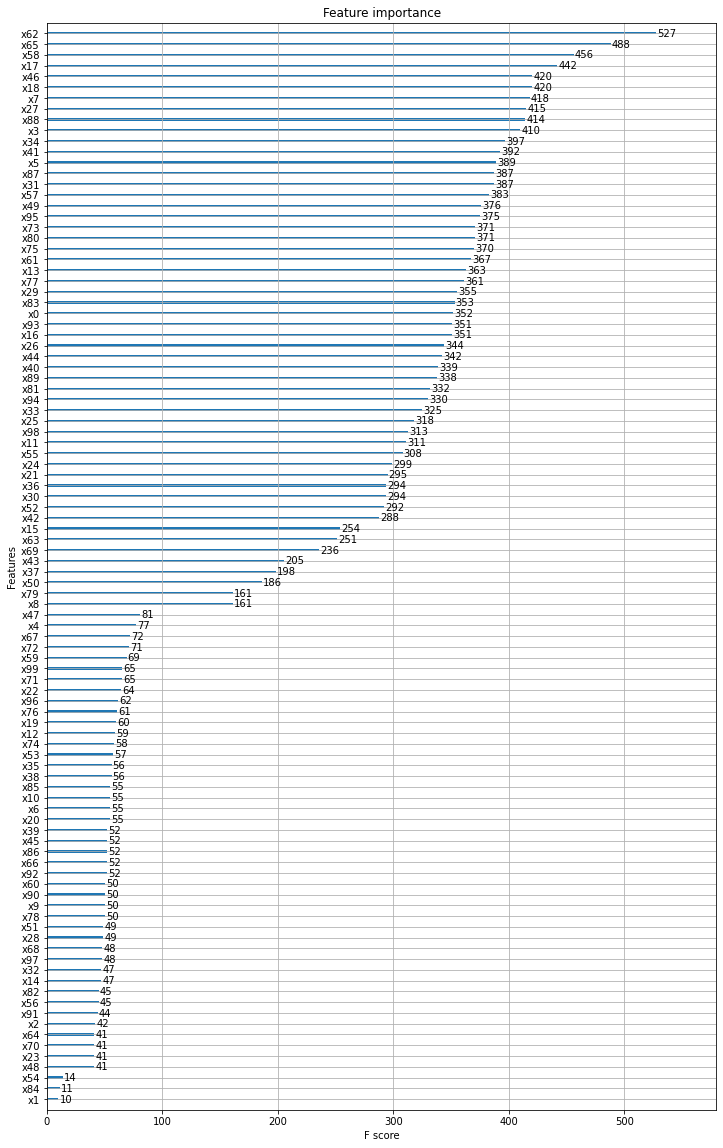

In [62]:
plt.rcParams["figure.figsize"] = (12, 20)
plot_importance(xgbc_md6);
plt.show()